# Kiva Crowdfunding

*Kiva.org is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world. Kiva lenders have provided over $1 billion dollars in loans to over 2 million people. In order to set investment priorities, help inform lenders, and understand their target communities, knowing the level of poverty of each borrower is critical. However, this requires inference based on a limited set of information for each borrower.*

## Prediction and Models

* Not all loan requests are funded (about 3383 records in loans dataset that are not funded). Is there a pattern among the loans not funded?  

* Group Loans into Clusters and identify Top Features [Unsupervised Learning]. 

* Predict if a loan request is likely to get funded or not [Logistic Regression] 


In [1]:
%matplotlib inline

# General libraries.
import re
import math
import numpy as np
import collections
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from mpl_toolkits.basemap import Basemap
color = sns.color_palette()
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, mixture # For clustering 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import feature_selection
    
import warnings
warnings.filterwarnings('ignore')

## EDA - LOOK AT THE OTHER FILE. THIS ONE IS JUST MODELS

### Kiva Loans

In [2]:
df_kiva_loans = pd.read_csv("kiva_loans.csv")
df_kiva_loans.head()
#df_kiva_loans.describe(include = 'all')

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


In [3]:
df_kiva_loans['borrower_genders'].value_counts()

female                                                                                                                                                                                                                                426502
male                                                                                                                                                                                                                                  134710
female, female                                                                                                                                                                                                                         12164
female, female, female                                                                                                                                                                                                                 11676
female, female, female, female                      

In [4]:
df_kiva_loans.describe()

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count
count,6.712050e+05,671205.000000,671205.000000,657698.000000,671205.000000,671205.000000
mean,9.932486e+05,785.995061,842.397107,178.199616,13.739022,20.590922
std,1.966113e+05,1130.398941,1198.660073,94.247581,8.598919,28.459551
min,6.530470e+05,0.000000,25.000000,9.000000,1.000000,0.000000
25%,8.230720e+05,250.000000,275.000000,126.000000,8.000000,7.000000
50%,9.927800e+05,450.000000,500.000000,145.000000,13.000000,13.000000
75%,1.163653e+06,900.000000,1000.000000,204.000000,14.000000,24.000000
max,1.340339e+06,100000.000000,100000.000000,536.000000,158.000000,2986.000000


** OBSERVATION: Funded Amount, Loan Amount and Lender Count are highly correlated**


In [5]:
# Identify rows with no funding (Funding amount = 0)
df_nofund = df_kiva_loans[(df_kiva_loans['funded_amount']==0)]
df_nofund.shape

(3383, 20)


 **OBSERVATION: There are about 3383 rows with funded amount = 0**  <font size="4">$\color{red}{\text{Is there any pattern among loans that are not funded?}}$ </font>


**OBSERVATION: Philippines, Kenya and El Salvador are the top 3 countries featuring in Loans dataset.  United States, Kenya and Pakistan are the countries top countries with loan amount not funded**

**OBSERVATION: Agriculture, Food and Retail are the top 3 sectors based on Loan Amount.  And these are the top 3 that are not getting funds **

** OBSERVATION: Farming is the top activity based on Loan Amount, followed by General Store and Personal Housing Expenses**

** OBSERVATION: There are more Female borrowers than male **

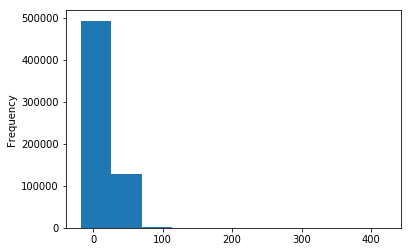

In [6]:
# Determine Time Taken for Funding. It is Loan Posted Time - Funded Time

df_funded = df_kiva_loans[(df_kiva_loans['funded_amount']!=0)]
df_funded.dropna()
df_funded.shape

df_funded['funded_time'] = pd.to_datetime(df_funded['funded_time'])
df_funded['posted_time'] = pd.to_datetime(df_funded['posted_time'])    
time_to_fund = (df_funded.funded_time - df_funded.posted_time)
time_to_fund_in_days = (time_to_fund.astype('timedelta64[s]')/(3600 * 24))
df_funded = df_funded.assign(time_to_fund=time_to_fund)
df_funded = df_funded.assign(time_to_fund_in_days=time_to_fund_in_days)
df_funded.time_to_fund_in_days.plot.hist();

In [7]:
countries_funded_amount = df_kiva_loans.groupby('country').mean()['funded_amount'].sort_values(ascending = False)
print("Top Countries with funded amount (Mean values)\n",countries_funded_amount.head(10))

Top Countries with funded amount (Mean values)
 country
Cote D'Ivoire         50000.000000
Mauritania            15000.000000
Bhutan                 7812.500000
Chile                  7625.000000
Afghanistan            7000.000000
Congo                  6142.578125
Puerto Rico            4409.191176
Dominican Republic     4200.604839
Namibia                4046.875000
United States          3800.843591
Name: funded_amount, dtype: float64


**OBSERVATION: Cote D'Ivoire, Mauritania, Bhutan got top funding**   

In [8]:
df_funded
funded_time = df_funded.groupby('country').mean()['time_to_fund_in_days'].sort_values(ascending = False)
print("Top Countries with max funded_time(Mean values)\n",funded_time.head(10))

Top Countries with max funded_time(Mean values)
 country
United States    39.544380
Puerto Rico      38.112630
Vanuatu          35.963452
El Salvador      22.054165
Azerbaijan       21.930762
Bolivia          21.458772
Georgia          20.976522
Armenia          20.607393
Colombia         20.366121
Kenya            20.161696
Name: time_to_fund_in_days, dtype: float64


**OBSERVATION: US, Puerto Rico, Vanuata take longer time for funding**

## MPI Region/Location

** OBSERVATION: As expected, Africa has the HIGHEST Poverty followed by South Asia **

# Models

## Model Selection

- Scaling and normalizing the data
- Dividing the data into a training and testing sets
- Evaluating an initial model
- Selecting the columns with the highest weights
- Creating the final model
- Measuring the model's performance

In [9]:
#normalised = StandardScaler()
#normalised.fit_transform(data)

## Pre-processing & Splitting

In [10]:
use_col = ['funded_amount', 'loan_amount', 'sector', 'country', 'term_in_months', 'lender_count', 'borrower_genders', 'repayment_interval']
df_loans = df_kiva_loans[use_col].copy()
df_loans.head()

,funded_amount,loan_amount,sector,country,term_in_months,lender_count,borrower_genders,repayment_interval
0,300.0,300.0,Food,Pakistan,12.0,12,female,irregular
1,575.0,575.0,Transportation,Pakistan,11.0,14,"female, female",irregular
2,150.0,150.0,Transportation,India,43.0,6,female,bullet
3,200.0,200.0,Arts,Pakistan,11.0,8,female,irregular
4,400.0,400.0,Food,Pakistan,14.0,16,female,monthly


In [11]:
df_loans['sector'].value_counts()

Agriculture       180302
Food              136657
Retail            124494
Services           45140
Personal Use       36385
Housing            33731
Clothing           32742
Education          31013
Transportation     15518
Arts               12060
Health              9223
Construction        6268
Manufacturing       6208
Entertainment        830
Wholesale            634
Name: sector, dtype: int64

In [12]:
df_loans.isnull().sum()

funded_amount            0
loan_amount              0
sector                   0
country                  0
term_in_months           0
lender_count             0
borrower_genders      4221
repayment_interval       0
dtype: int64

In [13]:
df_loans.dropna(inplace=True)

In [14]:
df_loans.shape

(666984, 8)

In [15]:
df_loans['percent_female'] = df_loans['borrower_genders'].apply(lambda x: np.mean(np.array(x.split(',')) == 'female'))
df_loans['applicants'] = df_loans['borrower_genders'].apply(lambda x: len(x.split(',')))
df_loans.drop('borrower_genders', axis=1, inplace=True)

In [16]:
df_loans.head()

,funded_amount,loan_amount,sector,country,term_in_months,lender_count,repayment_interval,percent_female,applicants
0,300.0,300.0,Food,Pakistan,12.0,12,irregular,1.0,1
1,575.0,575.0,Transportation,Pakistan,11.0,14,irregular,0.5,2
2,150.0,150.0,Transportation,India,43.0,6,bullet,1.0,1
3,200.0,200.0,Arts,Pakistan,11.0,8,irregular,1.0,1
4,400.0,400.0,Food,Pakistan,14.0,16,monthly,1.0,1


In [17]:
df_loans['granted'] = 1*(df_loans['loan_amount'] == df_loans['funded_amount'])
df_loans.drop('funded_amount', axis=1, inplace=True)

In [18]:
df_loans['granted'].value_counts()

1    619336
0     47648
Name: granted, dtype: int64

In [40]:
47648/(47648+619336)*100

7.143799551413527

In [19]:
df_loans.head()

,loan_amount,sector,country,term_in_months,lender_count,repayment_interval,percent_female,applicants,granted
0,300.0,Food,Pakistan,12.0,12,irregular,1.0,1,1
1,575.0,Transportation,Pakistan,11.0,14,irregular,0.5,2,1
2,150.0,Transportation,India,43.0,6,bullet,1.0,1,1
3,200.0,Arts,Pakistan,11.0,8,irregular,1.0,1,1
4,400.0,Food,Pakistan,14.0,16,monthly,1.0,1,1


In [20]:
df_loans.shape

(666984, 9)

In [21]:
df_loans = pd.concat((df_loans,pd.get_dummies(df_loans[['sector', 'country', 'repayment_interval']], drop_first=True)), axis=1)
df_loans.drop(['sector', 'country', 'repayment_interval'], axis=1, inplace=True)
df_loans.shape
df_loans.head()


,loan_amount,term_in_months,lender_count,percent_female,applicants,granted,sector_Arts,sector_Clothing,sector_Construction,sector_Education,...,country_United States,country_Vanuatu,country_Vietnam,country_Virgin Islands,country_Yemen,country_Zambia,country_Zimbabwe,repayment_interval_irregular,repayment_interval_monthly,repayment_interval_weekly
0,300.0,12.0,12,1.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,575.0,11.0,14,0.5,2,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,150.0,43.0,6,1.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,200.0,11.0,8,1.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,400.0,14.0,16,1.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [22]:
X = df_loans.drop('granted', axis=1).values
y = df_loans['granted'].values
print(X.shape)
print(y.shape)


(666984, 108)
(666984,)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Random Forest

In [24]:
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train, y_train)
#rfc.score(X_test, y_test)
score = rfc.score(X_test, y_test)
print("Score from Random Forest is %.2f%%" %(score*100))

Score from Random Forest is 95.99%


In [25]:
confusion_matrix(y_test, rfc.predict(X_test))
tn, fp, fn, tp = confusion_matrix(y_test, rfc.predict(X_test), labels=[0,1]).ravel()
print ('True Positive=', tp)
print ('False Positive=', fp)
print ('True Negative=', tn)
print ('False Negative=', fn)


True Positive= 201275
False Positive= 5789
True Negative= 10010
False Negative= 3031


In [26]:
(5711+3033)/(201273+5711+10088+3033)

0.0397264941732355

In [27]:
6740/(6740+9059)

0.4266092790682955

### Feature Importance from Random Forest

In [28]:
importances = pd.DataFrame({"Feature": df_loans.drop('granted', axis=1).columns, 'Score': rfc.feature_importances_})
importances = importances.sort_values(by='Score', ascending=False).head(10)

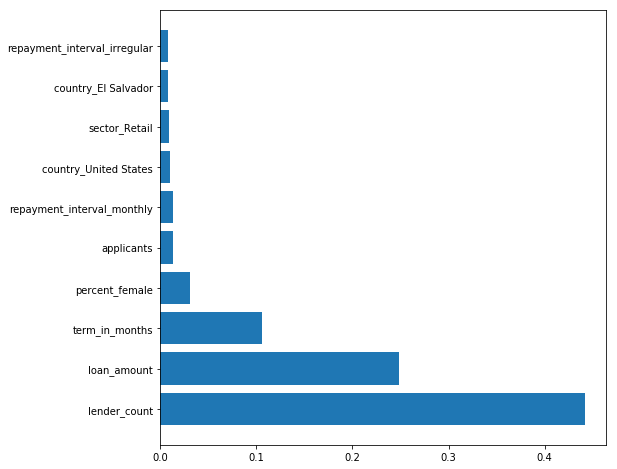

In [29]:
plt.figure(figsize=(8,8))
plt.barh(range(10), importances['Score'])
a = plt.yticks(range(10), importances['Feature'])

##  Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

## Logistic Regression

In [31]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print("Score from Logisitic Regression is %.2f%%" %(score*100))

Score from Logisitic Regression is 94.12%


## Recursive Feature Elimination

In [32]:
from sklearn.feature_selection import RFE
rfe = RFE(logisticRegr,3)
fit = rfe.fit(X_train, y_train)
print("Num Features:",  fit.n_features_)
print("Selected Features", fit.support_)
print("Feature Ranking", fit.ranking_)


Num Features: 3
Selected Features [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False]
Feature Ranking [ 97  88  95  31  90   8  53  34  20  80  68  77  54   3  71  52  76  62
  27  51  29  44  14  13 104  37  23  25  58  83  61 101  15  32  30  55
 105  78  74  19  33  72  96  99  93  12  59  66  35  16  11  40  57  36
  38   1  50   4  75   7  60  86 106  82  65  79  64  47 103   1  43  91


## SelectKBest

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X_train, y_train)
# summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X_train)
# summarize selected features
print(features[0:5,:])

[1.305e+07 5.196e+04 4.943e+04 2.723e+03 3.678e+02 3.903e+02 1.166e+02
 4.161e+01 6.758e+02 2.574e+01 2.212e+02 1.161e+00 7.348e+02 2.519e+02
 3.623e+02 1.277e+02 1.068e+02 2.472e+02 9.312e+00 2.967e+01 1.663e+03
 1.438e+02 6.830e+00 1.901e+01 7.674e-02 4.503e+02 1.121e+01 6.202e+01
 2.770e+00 3.664e+02 3.888e-01 2.302e-01 7.060e+00 2.826e+03 6.907e+00
 4.223e-01       nan 4.050e+00 9.607e+01 3.546e+01 4.609e+03 2.366e-01
 5.556e+01 1.303e+01 5.848e+00 1.197e+02 1.905e+00 2.061e+02 6.006e+01
 2.973e+01 9.746e+00 3.901e+00 1.142e+00 1.083e+02 7.915e+01 6.850e+01
 6.329e+00 2.172e+01 7.917e+01 1.430e+02 2.920e+01 4.595e+00       nan
 2.617e+01 7.580e-04 2.305e-01 4.640e+01 1.245e+02 3.070e-01 3.706e+01
 1.402e+02 8.147e+01 7.261e-01 2.180e+02 1.021e+01 2.329e+02 4.454e+02
 4.720e+03 1.766e+01 1.293e+01 8.441e-01 5.244e+01 4.858e+00 4.543e-01
 4.868e+00 3.837e+00 1.949e+01 6.830e+00 5.987e-01 2.252e+02 1.377e+01
 7.636e+00 2.505e+01 3.497e+00 1.421e+02 8.473e+01 3.715e+02 9.694e-01
 4.951

## PCA and Kmeans Clustering

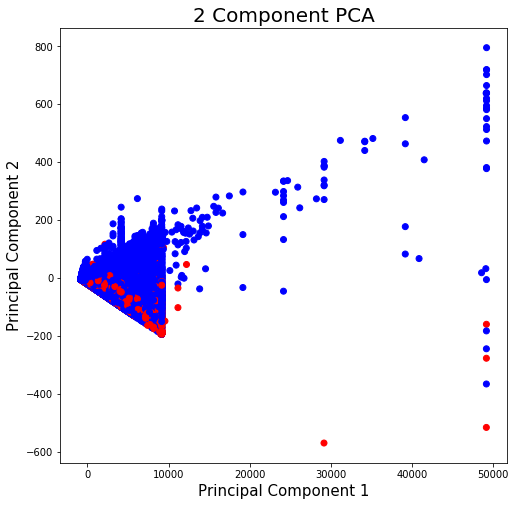

In [34]:
def apply_pca():
    pca = PCA(n_components=2)
    train_data_comp = pca.fit_transform(X_train)
    test_data_comp = pca.transform(X_test)
   
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
   
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 Component PCA', fontsize = 20)
    c= np.where(y_train==0,'r','b')
    ax.scatter(train_data_comp[:,0], train_data_comp[:,1], c=c)
    
    return pca

pca = apply_pca()


[0 0 0 ... 0 0 0]


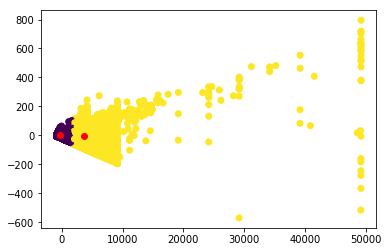

In [35]:
 
pca = PCA(n_components=10)
train_data_comp = pca.fit_transform(X_train)
test_data_comp = pca.transform(X_test)
trans_data = pca.fit(X_train).transform(X_train)
     
km = KMeans(n_clusters=2, init='k-means++')
clstrs = km.fit(trans_data)
print(km.labels_)

plt.scatter(train_data_comp[:,0], train_data_comp[:,1], c=clstrs.labels_)
plt.plot(clstrs.cluster_centers_[:,0], clstrs.cluster_centers_[:,1], 'ro')  
plt.show() 



In [36]:
pca.explained_variance_ratio_.sum()

0.9999993333284368

In [37]:
## Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X1 = scaler.transform(X_train)

## PCA projection to 2D
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X1)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [38]:
principalDf.head()
#finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

,principal component 1,principal component 2
0,-2.685455,0.793871
1,-0.259054,-0.082441
2,1.422649,-0.454800
3,-0.089749,-1.059129
4,-1.430957,0.375683


In [39]:
clf_pos = GMM(n_components=4, covariance_type='full')
clf_pos.fit(train_data_comp[y_train == 1, :])

clf_neg = GMM(n_components=4, covariance_type='full')
clf_neg.fit(train_data_comp[y_train == 0, :])

prob_pos = clf_pos.score_samples(test_data_comp)
prob_neg = clf_neg.score_samples(test_data_comp)
    
test_class1 = (prob_pos> prob_neg).astype(int)

print ("GMM Accuracy = %.2f%% percent" %(np.mean(test_class1 == y_test)*100))



GMM Accuracy = 73.27% percent
